# DataDiagnostics
**Feature balancing, feature selection, and others.** <br />
Julian Hsu
Date Created: 30 Mar 2021

This notebook creates several functions that diagnose a given dataset and whether it can estimate credible DSI. Specifically, it provides information for a science to evaluate whether the overlap condition is satisfied and information about feature balancing. 

Finally, it does a demonstration using simulated data as a proof of concept.

### How do I use this?
These functions are designed to be used in conjunction with your DSI workflow. The first few steps of the algorithm do are standard steps for using matching-based treatment effect models. 



1. You determine the features you are interested in $X_i$.   
2. You train a propensity model, $P(X_i)$.   
3. Understand your propensity score overlap with the function __propensity_overlap()__.  
4. Assess whether you can find good synthetic twins based on the propensity score by testing whether the features are balanced between treatment and control groups based on the $P(X_i)$. This uses the function __feature_balance()__.  
    *  __feature_balance()__ uses OLS to compare synthetic twins as a default. This is robust to extreme propensity scores. 
    * If you would like, this function also lets you compare with the inverse propensity weighting method. Check out the __feature_balance()__ API listed in the function below.  

5. [Optional] If you want to a summary of the results, the function __summarize_result_df()__ does this. 


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy.stats 
import statsmodels.api as sm

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import os as os 
from IPython.display import display    
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV, LogisticRegression


In [2]:
import stnomics as st

Come up with some simulation data and try the functions above.

In [3]:
def sim_data():
    N = 5000
    x1 = np.random.normal(0,1,N)
    x1_p90 = np.percentile(x1,90)
    x1[x1 > x1_p90] += x1[x1 > x1_p90]*2
    
    x2 = np.random.normal(0,1,N)
    x2_p80 = np.percentile(x2,80)
    x2[x2 < x2_p80] += x2[x2 < x2_p80]*2
    
    x3 = np.random.normal(0,1,N)
    
    x4 = np.random.randint(1,3, N)
    
    latent = np.random.uniform(0.5,1)*x1 + np.random.uniform(0.5,1)*x2 + np.random.uniform(-1,-0.5)*x3 + np.random.uniform(-0.75,0.25) * x4
    T = np.exp(latent)/ (1 + np.exp(latent)) > np.random.uniform(0,1,N) 

    df = pd.DataFrame( index=np.arange(N), data={'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'T':T} )
    return df

In [4]:

df = sim_data()
## Estimate a propensity score
from sklearn.linear_model import LogisticRegression
feature_list = ['x1','x2','x3','x4']
clf = LogisticRegression(random_state=0).fit(df[feature_list], df['T'].astype(bool))
df['pscore'] = clf.predict_proba(df[feature_list])[:,1]

clf = LogisticRegression(random_state=0).fit( np.array(df[['x1','x2']]) , df['T'].astype(bool))
df['pscore_poor'] = clf.predict_proba( np.array(df[['x1','x2']]) )[:,1]

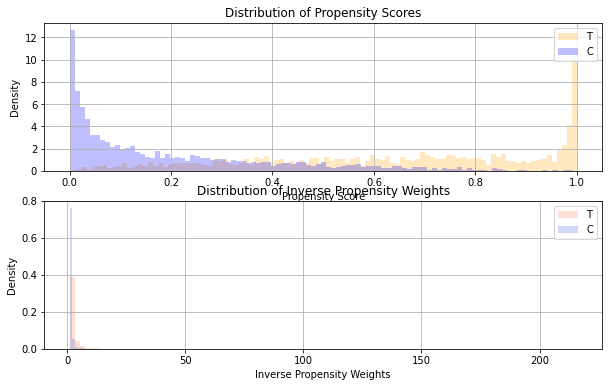

   Control N below  0.01: 411
 Treatment N below  0.01: 1

   Control N below  0.05: 1081
 Treatment N below  0.05: 18

   Control N below  0.10: 1503
 Treatment N below  0.10: 50

   Control N above  0.90: 11
 Treatment N above  0.90: 421

   Control N above  0.95: 8
 Treatment N above  0.95: 330

   Control N above  0.99: 1
 Treatment N above  0.99: 171



In [5]:
st.diagnostics.balance.propensity_overlap(df, 'pscore', 'T')


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

balance_df = st.diagnostics.balance.feature_balance(df,
                    feature_list, 'pscore', 'T',
                            'DML',RandomForestRegressor(n_jobs=-1))

display(balance_df)    

,feature,Raw Difference,Raw PValue,Raw TStat,Normalized Diff,OLS-PScore Difference,OLS-PScore PValue,OLS-PScore TStat,Raw Difference SD,Raw PValue SD,Raw TStat SD,OLS-PScore Difference SD,OLS-PScore PValue SD,OLS-PScore TStat SD
0,x1,1.703247,3.359907e-228,34.006346,0.635047,-0.004357,0.956224,-0.054895,0.908246,3.359907e-228,34.006346,-0.002603,0.950951,-0.061515
1,x2,1.771368,3.865749e-169,28.823353,0.637160,0.045276,0.632820,0.477791,0.791030,3.865749e-169,28.823353,0.017124,0.685632,0.404813
2,x3,-0.384922,2.176250e-39,-13.246140,-0.277334,0.029129,0.490538,0.689505,-0.385866,2.176250e-39,-13.246140,0.027584,0.515296,0.650659
3,x4,-0.103557,2.382835e-12,-7.027639,-0.147619,0.000847,0.967512,0.040731,-0.207259,2.382835e-12,-7.027639,0.005289,0.899081,0.126829


In [7]:
st.diagnostics.balance.summarize_result_df(balance_df)

,Raw Difference SD,OLS-PScore PValue SD,Stat Sig Raw Difference SD,Stat Sig OLS-PScore Difference SD
count,4.000000,4.000000,4.000000,0.0
mean,0.573100,0.762740,0.573100,NaN
std,0.331015,0.200986,0.331015,NaN
min,0.207259,0.515296,0.207259,NaN
25%,0.341214,0.643048,0.341214,NaN
50%,0.588448,0.792356,0.588448,NaN
75%,0.820334,0.912049,0.820334,NaN
max,0.908246,0.950951,0.908246,NaN


In [9]:
balance_df[['Raw Difference SD','OLS-PScore Difference SD']]

,Raw Difference SD,OLS-PScore Difference SD
0,0.908246,-0.002603
1,0.791030,0.017124
2,-0.385866,0.027584
3,-0.207259,0.005289


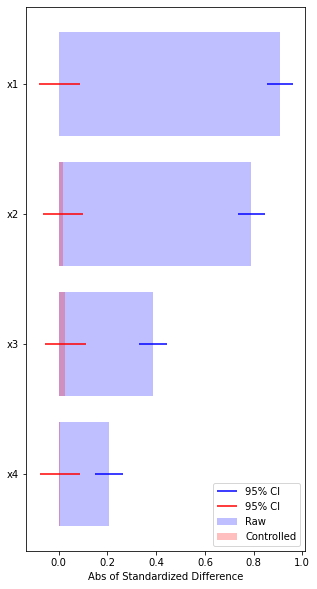

In [10]:
st.diagnostics.balance.plot_difference(balance_df, (5,10))

In [12]:
balance_df_poor = st.diagnostics.balance.feature_balance(df,
                    feature_list, 'pscore_poor', 'T',
                            'DML',RandomForestRegressor(n_jobs=-1))
display(balance_df_poor)
st.diagnostics.balance.summarize_result_df(balance_df_poor)

,feature,Raw Difference,Raw PValue,Raw TStat,Normalized Diff,OLS-PScore Difference,OLS-PScore PValue,OLS-PScore TStat,Raw Difference SD,Raw PValue SD,Raw TStat SD,OLS-PScore Difference SD,OLS-PScore PValue SD,OLS-PScore TStat SD
0,x1,1.703247,3.359907e-228,34.006346,0.635047,0.042225,5.814375e-01,0.551322,0.908246,3.359907e-228,34.006346,0.021067,6.058852e-01,0.515989
1,x2,1.771368,3.865749e-169,28.823353,0.637160,-0.003342,9.706407e-01,-0.036807,0.791030,3.865749e-169,28.823353,0.005910,8.842995e-01,0.145528
2,x3,-0.384922,2.176250e-39,-13.246140,-0.277334,-0.604979,3.557437e-51,-15.220856,-0.385866,2.176250e-39,-13.246140,-0.609928,2.080960e-51,-15.257520
3,x4,-0.103557,2.382835e-12,-7.027639,-0.147619,-0.170610,5.925526e-18,-8.666707,-0.207259,2.382835e-12,-7.027639,-0.340350,7.728668e-18,-8.635939


,Raw Difference SD,OLS-PScore PValue SD,Stat Sig Raw Difference SD,Stat Sig OLS-PScore Difference SD
count,4.000000,4.000000e+00,4.000000,2.000000
mean,0.573100,3.725462e-01,0.573100,0.475139
std,0.331015,4.449419e-01,0.331015,0.190621
min,0.207259,2.080960e-51,0.207259,0.340350
25%,0.341214,5.796501e-18,0.341214,0.407744
50%,0.588448,3.029426e-01,0.588448,0.475139
75%,0.820334,6.754888e-01,0.820334,0.542534
max,0.908246,8.842995e-01,0.908246,0.609928


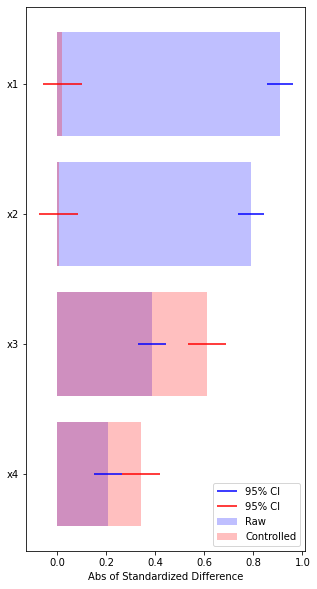

In [13]:
st.diagnostics.balance.plot_difference(balance_df_poor, (5,10))

### use simulations to show results are robust to randomness in data-generation

In [18]:
num_simulations = 100
unconfound_true = []
unconfound_false = []
for s in range(num_simulations):
    df = sim_data()
    feature_list = ['x1','x2','x3','x4']
    clf = LogisticRegression(random_state=0).fit(df[feature_list], df['T'].astype(bool))
    df['pscore'] = clf.predict_proba(df[feature_list])[:,1]

    missing_one = [feature_list[x] for x in np.random.choice(4,3,replace=False) ]  
    clf = LogisticRegression(random_state=0).fit( np.array(df[missing_one]) , df['T'].astype(bool))
    df['pscore_poor'] = clf.predict_proba( np.array(df[missing_one]) )[:,1]

    
    balance_df = st.diagnostics.balance.feature_balance(df,
                    feature_list, 'pscore', 'T',
                            'DML',RandomForestRegressor(n_jobs=-1))

    full_adjusted_pvalue_below_05 = balance_df.loc[balance_df['OLS-PScore PValue'] < 0.05].count()
    unconfound_true.append(full_adjusted_pvalue_below_05)
    
    balance_df = st.diagnostics.balance.feature_balance(df,
                    feature_list, 'pscore_poor', 'T',
                            'DML',RandomForestRegressor(n_jobs=-1))

    missing_adjusted_pvalue_below_05 = balance_df_poor.loc[balance_df_poor['OLS-PScore PValue'] < 0.05].count()    
    unconfound_false.append(missing_adjusted_pvalue_below_05)
    
print(' Average # of features where stat. sig. (5%) difference & unconfoundedness is true {0:5.3f}'.format(np.average(unconfound_true)))
print(' Average # of features where stat. sig. (5%) difference & unconfoundedness is false {0:5.3f}'.format(np.average(unconfound_false)))

 Average # of features where stat. sig. (5%) difference & unconfoundedness is true 0.000
 Average # of features where stat. sig. (5%) difference & unconfoundedness is false 2.000
